# Support Vector Machines
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alirezatheh/handson-ml3-notes/blob/main/notebooks/05_support_vector_machines.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/alirezatheh/handson-ml3-notes/blob/main/notebooks/05_support_vector_machines.ipynb)

## Linear SVM Classification
The idea behind SVMs is best explained with some visuals:

<center>
  <img 
    src="../images/05/large_margin_classification.png"
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

Above, the solid line in the plot on the right represents the decision boundary of an SVM classifier; this line not only separates the two classes but also stays as far away from the closest training instances as possible. We can think of an SVM classifier as fitting the widest possible street (parallel dashed lines) between the classes. This is called *large margin classification*. Notice that adding more training instances “off the street” will not affect the decision boundary at all: it is fully determined (or “supported”) by the instances located on the edge of the street. These instances are called the *support vectors*.

**Warning**: SVMs are sensitive to the feature scales.

<center>
  <img 
    src="../images/05/sensitivity_to_feature_scales.png"
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

### Soft Margin Classification
If we strictly impose that all instances must be off the street and on the correct side, this is called *hard margin classification*. This has two main issues:
- It only works if the data is *linearly separable*.
- It is sensitive to outliers.

<center>
  <img 
    src="../images/05/hard_margin_issues.png"
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

To avoid these issues, we need to use a more flexible model. The objective is to find a good balance between keeping the street as large as possible and limiting the *margin violations*. This is called *soft margin classification*.

In Scikit-Learn we use `C` hyperparameter:
- low `C`: Large street
- high `C`: Small street

**Tip**: If an SVM model is overfitting, we can try regularizing it by reducing `C`.

Let's loads the iris dataset and train a linear SVM classifier to detect *Iris virginica* flowers:

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
# Iris virginica
y = iris.target == 2

svm_clf = make_pipeline(
    StandardScaler(), LinearSVC(C=1, dual=True, random_state=42)
)
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

In [2]:
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

`LinearSVC` doesn’t have a `predict_proba()` method:

In [3]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.22036063])

If we use the `SVC` class, and if we set `probability=True`, the model will fit an extra model at the end of training to map the SVM decision function scores to estimated probabilities. This will slow down training considerably.

## Nonlinear SVM Classification
We can add polynomial features as before. Here adding $x_2=(x_1)^2$ made the dataset linearly seperable:

<center>
  <img 
    src="../images/05/polynomial_features.png"
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

Let’s test this on the moons dataset:

In [4]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, dual=True, random_state=42),
)
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

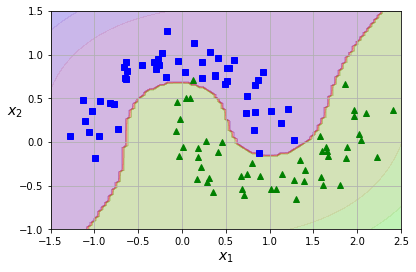

In [5]:
from typing import List

import matplotlib.pyplot as plt
from numpy.typing import ArrayLike
from sklearn.pipeline import Pipeline

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


def plot_dataset(X: ArrayLike, y: ArrayLike, axes: List[float]) -> None:
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'bs')
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'g^')
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$', rotation=0)


def plot_predictions(clf: Pipeline, axes: List[float]) -> None:
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)


plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### Polynomial Kernel
When using SVMs we can apply an almost miraculous mathematical technique called the *kernel trick*. It gets the same result as if we had added many polynomial features, even with a very high degree, without actually having to add them. This trick is implemented by the `SVC` class:

In [6]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(
    StandardScaler(), SVC(kernel='poly', degree=3, coef0=1, C=5)
)
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

Let's try a different `coef0` and then compare them:

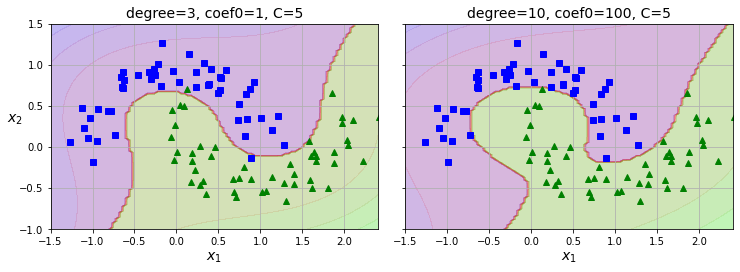

In [7]:
poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(), SVC(kernel='poly', degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title('degree=3, coef0=1, C=5')

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title('degree=10, coef0=100, C=5')
plt.ylabel('')

plt.show()

The hyperparameter `coef0` controls how much the model is influenced by high-degree terms versus low-degree terms.

### Similarity Features
Another technique is to add features computed using a similarity function, which measures how much each instance resembles a particular *landmark*. Here similarity features $x_2$ and $x_3$ using the Gaussian RBF made the dataset linearly separable:

<center>
  <img 
    src="../images/05/similarity_features.png"
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

How to select the landmarks? The simplest approach is to create a landmark at the location of each and every instance in the dataset. The downside is that after that we'll have $m$ features (droping originals).

### Gaussian RBF Kernel
Once again the kernel trick does its SVM magic, and gives similar result as if we had added many similarity features:

In [8]:
rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(), SVC(kernel='rbf', gamma=5, C=0.001)
)
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

Let's try various `gamma` and `C` and then compare them:

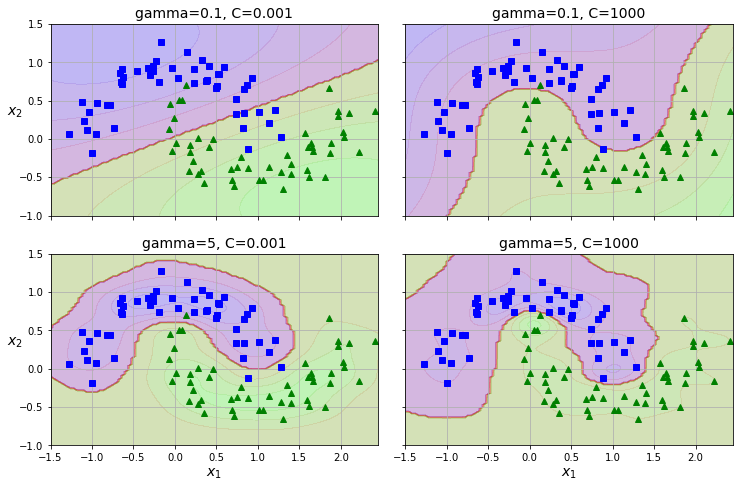

In [9]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(), SVC(kernel='rbf', gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True
)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f'gamma={gamma}, C={C}')
    if i in (0, 1):
        plt.xlabel('')
    if i in (1, 3):
        plt.ylabel('')

plt.show()

Other kernels exist but are used much more rarely. Some kernels are specialized for specific data structures. *String kernels* are sometimes used when classifying text documents or DNA sequences (e.g., using the string subsequence kernel or kernels based on the Levenshtein distance).

**Tip**: Which kernel to use? Start with `LinearSVC` and then RBF.

### SVM Classes and Computational Complexity
| Class           | Time complexicty                     | Out-of-core support | Scaling required | Kernel trick |
|:----------------|:-------------------------------------|:--------------------|:-----------------|:-------------|
| `LinearSVC`     | $O(m\times n)$                       | No                  | Yes              | No           |
| `SVC`           | $O(m^2\times n)$ to $O(m^3\times n)$ | No                  | Yes              | Yes          |
| `SGDClassifier` | $O(m\times n)$                       | Yes                 | Yes              | No           |

The `LinearSVC` class is based on the `liblinear` library, which implements an optimized algorithm for linear SVMs by Chih-Jen Lin et al. in a 2008 paper [“A Dual Coordinate Descent Method for Large-Scale Linear SVM”](https://homl.info/13). The algorithm takes longer if we require very high precision. This is controlled by the tolerace hyperparameter $\epsilon$ (called `tol` in Scikit-Learn).

The `SVC` class is based on the `libsvm` library, which implements an algorithm that supports the kernel trick by John Platt, in a 1998 paper [“Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines”](https://homl.info/14).

The `SGDClassifier` class also performs large margin classification by default.

## SVM Regression
To use SVMs for regression, the trick is to tweak the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, tries to fit as many instances as possible on the street while limiting margin violations (i.e., instances *off* the street). The width of the street is controlled by a hyperparameter, $\epsilon$. Reducing $\epsilon$ increases the number of support vectors, which regularizes the model. If we add more training instances within the margin, it will not affect the model’s predictions; thus, the model is said to be $\epsilon$*-insensitive*.

In [10]:
from sklearn.svm import LinearSVR

np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(
    StandardScaler(), LinearSVR(epsilon=0.5, dual=True, random_state=42)
)
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=0.5, random_state=42))])

Let's try an different `epsilon` and then compare them:

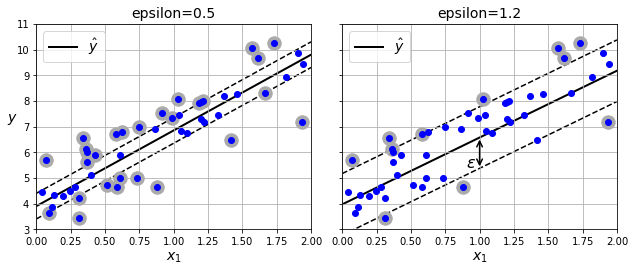

In [11]:
def find_support_vectors(
    svm_reg: Pipeline, X: ArrayLike, y: ArrayLike
) -> ArrayLike:
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)


def plot_svm_regression(
    svm_reg: Pipeline, X: ArrayLike, y: ArrayLike, axes: List[float]
) -> None:
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, 'k-', linewidth=2, label=r'$\hat{y}$', zorder=-2)
    plt.plot(x1s, y_pred + epsilon, 'k--', zorder=-2)
    plt.plot(x1s, y_pred - epsilon, 'k--', zorder=-2)
    plt.scatter(
        X[svm_reg._support],
        y[svm_reg._support],
        s=180,
        facecolors='#AAA',
        zorder=-1,
    )
    plt.plot(X, y, 'bo')
    plt.xlabel('$x_1$')
    plt.legend(loc='upper left')
    plt.axis(axes)


svm_reg2 = make_pipeline(
    StandardScaler(), LinearSVR(epsilon=1.2, dual=True, random_state=42)
)
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(f'epsilon={svm_reg[-1].epsilon}')
plt.ylabel('$y$', rotation=0)
plt.grid()
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f'epsilon={svm_reg2[-1].epsilon}')
plt.annotate(
    '',
    xy=(eps_x1, eps_y_pred),
    xycoords='data',
    xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
    textcoords='data',
    arrowprops={'arrowstyle': '<->', 'linewidth': 1.5},
)
plt.text(0.90, 5.4, r'$\epsilon$', fontsize=16)
plt.grid()
plt.show()

In [12]:
from sklearn.svm import SVR

np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(
    StandardScaler(), SVR(kernel='poly', degree=2, C=0.01, epsilon=0.1)
)
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

Let's try a different `C` and then compare them:

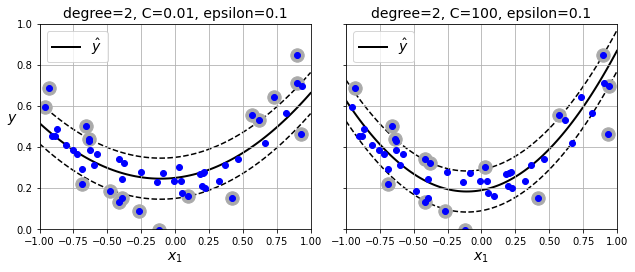

In [13]:
svm_poly_reg2 = make_pipeline(
    StandardScaler(), SVR(kernel='poly', degree=2, C=100)
)
svm_poly_reg2.fit(X, y)

svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title(
    f'degree={svm_poly_reg[-1].degree}, '
    f'C={svm_poly_reg[-1].C}, '
    f'epsilon={svm_poly_reg[-1].epsilon}'
)
plt.ylabel('$y$', rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(
    f'degree={svm_poly_reg2[-1].degree}, '
    f'C={svm_poly_reg2[-1].C}, '
    f'epsilon={svm_poly_reg2[-1].epsilon}'
)
plt.grid()
plt.show()

**Note**: SVMs can also be used for novelty detection.

## Under the Hood of Linear SVM Classifiers
**Note**: From now we will use $\mathbf{w}$ and $b$ instead of $\boldsymbol{\theta}$.

For predictions if $\mathbf{w}^\top\mathbf{x}+b$ is positive $\widehat{y}=1$ else $\widehat{y}=0$. For training let's start with the width of the street: to make it larger, we need to make $\mathbf{w}$ smaller. Let’s define the borders of the street as the points where the decision function is equal to –1 or +1.

<center>
  <img 
    src="../images/05/small_w_large_margin.png"
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

So, we need to keep $\mathbf{w}$ as small as possible. The bias term $b$ has no influence on the size of the margin: tweaking it just shifts the margin around, without affecting its size. We also want to avoid margin violations, so we need the decision function to be greater than 1 for all positive training instances and lower than –1 for negative training instances.

**Equation 5-1** Hard margin linear SVM classifier objective
$$
\begin{split}
&\underset{\mathbf{w},b}{\text{minimize}}\;\frac{1}{2}\mathbf{w}^\top\mathbf{w}
\\&\text{subject to}\;t^{(i)}(\mathbf{w}^\top\mathbf{x}^{(i)}+b)\ge1
\;\;\text{for}\;i=1,2,\cdots,m
\\&\text{where}\;t^{(i)}=\begin{cases}
1&\text{for positive instances ($y^{(i)}=1$)}
\\0&\text{for negative instances ($y^{(i)}=0$)}
\end{cases}
\end{split}
$$

**Note**: We are minimizing $\tfrac{1}{2}\|\mathbf{w}\|^2$ instead of $\|\mathbf{w}\|$ because it is not differentiable at $\mathbf{w}=0$. Optimization algorithms often work much better on differentiable functions.

For soft margin objective, we introduce a slack variable $\zeta^{(i)}\ge0$ for each instance: $\zeta^{(i)}$ measures how much the $i^\text{th}$ instance is allowed to violate the margin. We need the slack variables to be as small as possible to reduce the margin violations, and $\tfrac{1}{2}\mathbf{w}^\top\mathbf{w}$ to be as small as possible to increase the margin. The `C` hyperparameter controls this trade-off.

**Equation 5-2** Soft margin linear SVM classifier objective
$$
\begin{split}
&\underset{\mathbf{w},b,\zeta}{\text{minimize}}
\;\frac{1}{2}\mathbf{w}^\top\mathbf{w}+C\sum_{i=1}^m\zeta^{(i)}
\\&\text{subject to}\;t^{(i)}(\mathbf{w}^\top\mathbf{x}+b)\ge1-\zeta^{(i)}
\;\text{and}\;\zeta^{(i)}\ge0\;\;\text{for}\;i=1,2,\cdots,m
\end{split}
$$

The hard margin and soft margin problems are both convex quadratic optimization problems with linear constraints. Such problems are known as *quadratic programming* (QP) problems.

Using a QP solver is one way to train an SVM. Another is to use gradient descent to minimize the *hinge loss* or the *squared hinge loss*.

<center>
  <img 
    src="../images/05/hinge_loss.png"
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

### Extra Material - Linear SVM classifier implementation using Batch Gradient Descent

In [14]:
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = iris.target == 2

In [15]:
from typing import Optional

from sklearn.base import BaseEstimator
from typing_extensions import Self


class MyLinearSVC(BaseEstimator):
    def __init__(
        self,
        C: float = 1,
        eta0: int = 1,
        eta_d: int = 10000,
        n_epochs: int = 1000,
        random_state: Optional[int] = None,
    ) -> None:
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch: int) -> float:
        return self.eta0 / (epoch + self.eta_d)

    def fit(self, X: ArrayLike, y: ArrayLike) -> Self:
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        # n feature weights
        w = np.random.randn(X.shape[1], 1)
        b = 0

        t = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1
        X_t = X * t
        self.Js = []

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1 / 2 * (w * w).sum() + self.C * (
                (1 - X_t_sv.dot(w)).sum() - b * t_sv.sum()
            )
            self.Js.append(J)

            w_gradient_vector = w - self.C * X_t_sv.sum(axis=0).reshape(-1, 1)
            b_derivative = -self.C * t_sv.sum()

            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X: ArrayLike) -> ArrayLike:
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X: ArrayLike) -> ArrayLike:
        return self.decision_function(X) >= 0

In [16]:
C = 2
svm_clf = MyLinearSVC(C=C, eta0=10, eta_d=1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[ True],
       [False]])

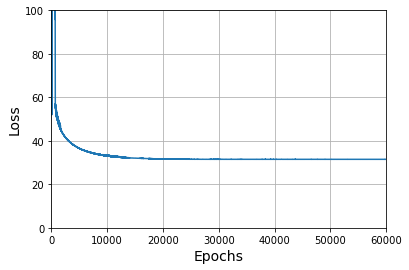

In [17]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [18]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [19]:
svm_clf2 = SVC(kernel='linear', C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


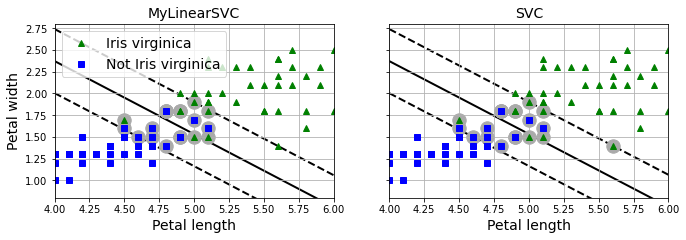

In [20]:
def plot_svc_decision_boundary(
    svm_clf: Pipeline,
    xmin: float,
    xmax: float,
) -> None:
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1 / w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA', zorder=-1)


yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr == 1], X[:, 1][yr == 1], 'g^', label='Iris virginica')
plt.plot(X[:, 0][yr == 0], X[:, 1][yr == 0], 'bs', label='Not Iris virginica')
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.title('MyLinearSVC')
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc='upper left')
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][yr == 1], X[:, 1][yr == 1], 'g^')
plt.plot(X[:, 0][yr == 0], X[:, 1][yr == 0], 'bs')
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel('Petal length')
plt.title('SVC')
plt.axis([4, 6, 0.8, 2.8])
plt.grid()

plt.show()

[-12.52988101   1.94162342   1.84544824]


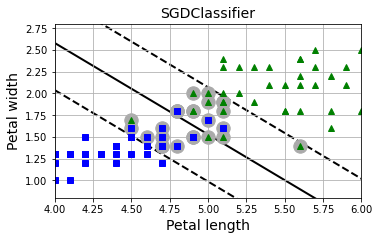

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(
    loss='hinge', alpha=0.017, max_iter=1000, tol=1e-3, random_state=42
)
sgd_clf.fit(X, y)

m = len(X)
# -1 if y == 0, or +1 if y == 1
t = np.array(y).reshape(-1, 1) * 2 - 1
# Add bias input x0=1
X_b = np.c_[np.ones((m, 1)), X]
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5, 3.2))
plt.plot(X[:, 0][yr == 1], X[:, 1][yr == 1], 'g^')
plt.plot(X[:, 0][yr == 0], X[:, 1][yr == 0], 'bs')
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.title('SGDClassifier')
plt.axis([4, 6, 0.8, 2.8])
plt.grid()

plt.show()

## The Dual Problem
Given a constrained optimization problem, known as the *primal problem*, it is possible to express a different but closely related problem, called its *dual problem*. The solution to the dual problem typically gives a lower bound to the solution of the primal problem. But when the objective function is convex, and the inequality constraints are continuously differentiable and convex functions, the dual can have the same solution as the primal problem.

**Equation 5-3** Dual form of the linear SVM objective
$$
\begin{split}
&\underset{\mathbf{α}}{\text{minimize}}
\;\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\alpha^{(i)}\alpha^{(j)}t^{(i)}t^{(j)}
{\mathbf{x}^{(i)}}^\top\mathbf{x}^{(j)}
-\sum_{i=1}^m\alpha^{(i)}
\\&\text{subject to}\;\alpha^{(i)}\ge0\;\text{for all}\;i=1,2,\cdots,m
\;\;\text{and}\;\;\sum_{i=1}^m\alpha^{(i)}t^{(i)}=0
\end{split}
$$

Once we find the vector $\widehat{\boldsymbol{\alpha}}$ that minimizes this equation (using a QP solver), use the following equation to compute the $\widehat{\mathbf{w}}$ and $\widehat{b}$ that minimize the primal problem.

<a id="equation-5-4"></a>

**Equation 5-4** From the dual solution to the primal solution
$$
\begin{split}
&\widehat{\mathbf{w}}=\sum_{i=1}^m\alpha^{(i)}t^{(i)}\mathbf{x}^{(i)}
\\&\widehat{b}
=\frac{1}{n_s}
\sum_{\begin{gathered}i=1\\\widehat{\alpha}^{(i)}>0\end{gathered}}^m
(t^{(i)}-\widehat{\mathbf{w}}^\top\mathbf{x}^{(i)})
\end{split}
$$
- $n_s$: The number of support vectors

When $m < n$ solving dual is faster than the primal and the dual problem makes the kernel trick possible.

### Kernelized SVMs
Suppose we want to apply a second-degree polynomial transformation to a two-dimensional training set.

**Equation 5-5** Second-degree polynomial mapping
$$
\varphi(\mathbf{x})
=\varphi(\begin{pmatrix}x_1\\x_2\end{pmatrix})
=\begin{pmatrix}x_1^2\\\sqrt2x_1x_2\\x_2^2\end{pmatrix}
$$

Now let’s look at what happens to a couple of 2D vectors, $\mathbf{a}$ and $\mathbf{b}$, if we apply this mapping and then compute the dot product of the transformed vectors:

**Equation 5-6** Kernel trick for a second-degree polynomial mapping
$$
\begin{split}
\varphi(\mathbf{a})^\top\varphi(\mathbf{b})&=
\begin{pmatrix}a_1^2\\\sqrt2a_1a_2\\a_2^2\end{pmatrix}
\begin{pmatrix}b_1^2\\\sqrt2b_1b_2\\b_2^2\end{pmatrix}
=a_1^2b_1^2+2a_1b_1a_2b_2+a_2^2b_2^2=(a_1b_1+a_2b_2)^2
\\&=\left(\begin{pmatrix}a_1\\a_2\end{pmatrix}^\top
\begin{pmatrix}a_1\\ a_2\end{pmatrix}\right)^2
=(\mathbf{a}^\top\mathbf{b})^2
\end{split}
$$

If we apply the transformation $\phi$ to all training instances, then the dual problem will contains dot product of transformed instances. Then instead of transforming dataset we can just replace $\phi(\mathbf{x}^{(i)})^\top\phi(\mathbf{x}^{(j)})$ with ${(\mathbf{x}^{(i)}}^\top\mathbf{x}^{(j)})^2$.

The function $K(\mathbf{a},\mathbf{b})=(\mathbf{a}^\top\mathbf{b})^2$ is a second-degree polynomial kernel. In machine learning, a *kernel* is a function capable of computing the dot product $\phi(\mathbf{a})^\top\phi(\mathbf{b})$, based only on the original vectors $\mathbf{a}$ and $\mathbf{b}$, without having to compute (or even to know about) the transformation $\phi$. Here is some of the most commonly used kernels:

**Equation 5-7** Common kernels
$$
\begin{split}
\text{Linear:}&\;\;K(\mathbf{a},\mathbf{b})=\mathbf{a}^\top\mathbf{b}
\\\text{Polynomial:}&\;\;K(\mathbf{a},\mathbf{b})
=(\gamma\mathbf{a}^\top\mathbf{b}+r)^d
\\\text{Gaussian RBF:}&\;\;K(\mathbf{a},\mathbf{b}
)=\exp(-\gamma\|\mathbf{a}-\mathbf{b}\|^2)
\\\text{Sigmoid:}&\;\;K(\mathbf{a},\mathbf{b})
=\tanh(\gamma\mathbf{a}^\top\mathbf{b}+r)
\end{split}
$$

<div style="border: 1px solid;">

#### Mercer’s Theorem
According to *Mercer’s theorem*, if a function $K(\mathbf{a},\mathbf{b})$ respects a few mathematical conditions called *Mercer’s conditions* (e.g., $K$ must be continuous and symmetric in its arguments so that $K(\mathbf{a},\mathbf{b})=K(\mathbf{b},\mathbf{a})$, etc.), then there exists a function $\phi$ that maps $\mathbf{a}$ and $\mathbf{b}$ into another space (possibly with much higher dimensions) such that $K(\mathbf{a},\mathbf{b})=\phi(\mathbf{a})^\top\phi(\mathbf{b})$. We can use $K$ as a kernel because we know $\phi$ exists, even if we don’t know what $\phi$ is. In the case of the Gaussian RBF kernel, it can be shown that $\phi$ maps each training instance to an infinite-dimensional space, so it’s a good thing we don’t need to actually perform the mapping!
</div>

If we use the kernel trick [Eqaution 5-4](#equation-5-4) will contatin $\phi(\mathbf{x}^{(i)})$ and we can't compute that. But we can plug the formula for $\widehat{\mathbf{w}}$ from [Eqaution 5-4](#equation-5-4) into the decision function, and we get an equation with only dot products between input vectors:

**Equation 5-8** Making predictions with a kernelized SVM
$$
\begin{split}
h_{\widehat{\mathbf{w}},\widehat{b}}(\varphi(\mathbf{x}^{(n)}))
&=\widehat{\mathbf{w}}^\top\varphi(\mathbf{x}^{(n)})+\widehat{b}
=\left(\sum_{i=1}^m\alpha^{(i)}t^{(i)}\varphi(\mathbf{x}^{(i)})\right)^\top
\varphi(\mathbf{x}^{(n)})+\widehat{b}
\\&=\sum_{i=1}^m\alpha^{(i)}t^{(i)}\left(\varphi(\mathbf{x}^{(i)})^\top
\varphi(\mathbf{x}^{(n)})\right)+\widehat{b}
\\&=\sum_{\begin{gathered}i=1\\\widehat{\alpha}^{(i)}>0\end{gathered}}^m
\alpha^{(i)}t^{(i)}K(\mathbf{x}^{(i)},\mathbf{x}^{(n)})+\widehat{b}
\end{split}
$$
- $\mathbf{x}^{(n)}$: A new instance

**Note**: $\alpha^{(i)}\neq0$ only for support vectors.

**Equation 5-9** Using the kernel trick to compute the bias term
$$
\begin{split}
\widehat{b}&
=\frac{1}{n_s}
\sum_{\begin{gathered}i=1\\\widehat{\alpha}^{(i)}>0\end{gathered}}^m
\left(t^{(i)}-\widehat{\mathbf{w}}^\top\varphi(\mathbf{x}^{(i)})\right)
\\&=\frac{1}{n_s}
\sum_{\begin{gathered}i=1\\\widehat{\alpha}^{(i)}>0\end{gathered}}^m
\left(t^{(i)}-\left(\sum_{j=1}^m\alpha^{(j)}
t^{(j)}\varphi(\mathbf{x}^{(j)})\right)^\top
\varphi(\mathbf{x}^{(i)})\right)
\\&=\frac{1}{n_s}
\sum_{\begin{gathered}i=1\\\widehat{\alpha}^{(i)}>0\end{gathered}}^m
\left(t^{(i)}
-\sum_{\begin{gathered}i=1\\\widehat{\alpha}^{(i)}>0\end{gathered}}^m
\alpha^{(j)}t^{(j)}K(\mathbf{x}^{(i)},\mathbf{x}^{(j)})\right)
\end{split}
$$

**Note**: It is also possible to implement online kernelized SVMs, capable of incremental learning, as described in the papers [“Incremental and Decremental Support Vector Machine Learning”](https://homl.info/17) by Gert Cauwenberghs and Tomaso Poggio in 2000 and [“Fast Kernel Classifiers with Online and Active Learning”](https://homl.info/18) by Antoine Bordes et al. in 2005.

## Exercises

### 1. to 9.
1. What is the fundamental idea behind support vector machines?
> The fundamental idea is to fit the widest possible "street" between the classes. In other words, the goal is to have the largest possible margin between the decision boundary that separates the two classes and the training instances. When performing soft margin classification, the SVM searches for a compromise between perfectly separating the two classes and having the widest possible street (i.e., a few instances may end up on the street). Another key idea is to use kernels when training on nonlinear datasets. SVMs can also be tweaked to perform linear and nonlinear regression, as well as novelty detection.
2. What is a support vector?
> After training an SVM, a *support vector* is any instance located on the "street" (see the previous answer), including its border. The decision boundary is entirely determined by the support vectors. Any instance that is *not* a support vector (i.e., is off the street) has no influence whatsoever; we could remove them, add more instances, or move them around, and as long as they stay off the street they won't affect the decision boundary. Computing the predictions with a kernelized SVM only involves the support vectors, not the whole training set.
3. Why is it important to scale the inputs when using SVMs?
> SVMs try to fit the largest possible "street" between the classes (see the first answer), so if the training set is not scaled, the SVM will tend to neglect small features.
4. Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?
> We can use the `decision_function()` method to get confidence scores. These scores represent the distance between the instance and the decision boundary. However, they cannot be directly converted into an estimation of the class probability. If we set `probability=True` when creating an `SVC`, then at the end of training it will use 5-fold cross-validation to generate out-of-sample scores for the training samples, and it will train a `LogisticRegression` model to map these scores to estimated probabilities. The `predict_proba()` and `predict_log_proba()` methods will then be available.
5. How can we choose between `LinearSVC`, `SVC`, and `SGDClassifier`?
> All three classes can be used for large-margin linear classification. The `SVC` class also supports the kernel trick, which makes it capable of handling nonlinear tasks. However, this comes at a cost: the `SVC` class does not scale well to datasets with many instances. It does scale well to a large number of features, though. The `LinearSVC` class implements an optimized algorithm for linear SVMs, while `SGDClassifier` uses Stochastic Gradient Descent. Depending on the dataset `LinearSVC` may be a bit faster than `SGDClassifier`, but not always, and `SGDClassifier` is more flexible, plus it supports incremental learning.
6. Say we’ve trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should we increase or decrease $\gamma$ (`gamma`)? What about `C`?
> If an SVM classifier trained with an RBF kernel underfits the training set, there might be too much regularization. To decrease it, we need to increase `gamma` or `C` (or both).
7. What does it mean for a model to be $\epsilon$*-insensitive*?
> A Regression SVM model tries to fit as many instances within a small margin around its predictions. If we add instances within this margin, the model will not be affected at all: it is said to be $\epsilon$*-insensitive*.
8. What is the point of using the kernel trick?
> The kernel trick is mathematical technique that makes it possible to train a nonlinear SVM model. The resulting model is equivalent to mapping the inputs to another space using a nonlinear transformation, then training a linear SVM on the resulting high-dimensional inputs. The kernel trick gives the same result without having to transform the inputs at all.
9. Train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if we can get them to produce roughly the same model.
>  Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

In [22]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

> Now let's build and train 3 models:
> - Remember that `LinearSVC` uses `loss='squared_hinge'` by default, so if we want all 3 models to produce similar results, we need to set `loss='hinge'`.
> - Also, the `SVC` class uses an RBF kernel by default, so we need to set `kernel='linear'` to get similar results as the other two models.
> - Lastly, the `SGDClassifier` class does not have a `C` hyperparameter, but it has another regularization hyperparameter called `alpha`, so we can tweak it to get similar results as the other two models.

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

C = 5
alpha = 0.05

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf = LinearSVC(loss='hinge', C=C, dual=True, random_state=42).fit(
    X_scaled, y
)
svc_clf = SVC(kernel='linear', C=C).fit(X_scaled, y)
sgd_clf = SGDClassifier(alpha=alpha, random_state=42).fit(X_scaled, y)

> Let's plot the decision boundaries of these three models:

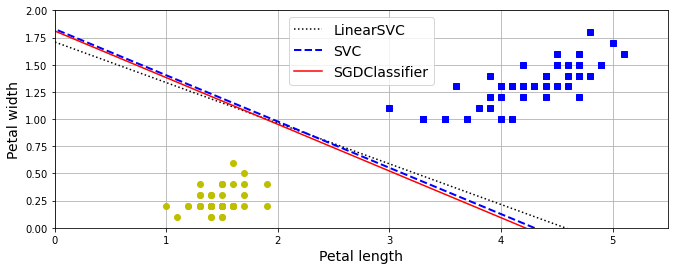

In [24]:
def compute_decision_boundary(model: Pipeline) -> ArrayLike:
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])


lin_line = compute_decision_boundary(lin_clf)
svc_line = compute_decision_boundary(svc_clf)
sgd_line = compute_decision_boundary(sgd_clf)

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], 'k:', label='LinearSVC')
plt.plot(svc_line[:, 0], svc_line[:, 1], 'b--', linewidth=2, label='SVC')
plt.plot(sgd_line[:, 0], sgd_line[:, 1], 'r-', label='SGDClassifier')
# label='Iris versicolor'
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
# label='Iris setosa'
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'yo')
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend(loc='upper center')
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

> Close enough!

### 10. 
Train an SVM classifier on the wine dataset, which we can load using `sklearn.datasets.load_wine()`. This dataset contains the chemical analysis of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine's chemical analysis. Since SVM classifiers are binary classifiers, we will need to use one-versus-all to classify all 3 classes. What accuracy can we reach?
> First, let's fetch the dataset, look at its description, then split it into a training set and a test set:

In [25]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

In [26]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
<<26 more lines>>
wine.

Original Owners: 

Forina, M. et al, PARVUS - 
An Extendible Package for Data Exploration, Classification and Correlation. 
Inst

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, random_state=42
)

In [28]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [29]:
y_train.head()

2      0
100    1
122    1
154    2
51     0
Name: target, dtype: int64

> Let's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy, so there's  nothing special we need to do to handle multiple classes. Easy, right?

In [30]:
lin_clf = LinearSVC(dual=True, random_state=42)
lin_clf.fit(X_train, y_train)

/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

> Oh no! It failed to converge. Can we guess why? Do we must just increase the number of training iterations? Let's see:

In [31]:
lin_clf = LinearSVC(max_iter=1_000_000, dual=True, random_state=42)
lin_clf.fit(X_train, y_train)

/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=1000000, random_state=42)

> Even with one million iterations, it still did not converge. There must be another problem. Let's still evaluate this model with `cross_val_score`, it will serve as a baseline:

In [32]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.90997150997151

> Well 91% accuracy on this dataset is not great. So did we guess what the problem is? That's right, we forgot to scale the features! Always remember to scale the features when using SVMs:

In [33]:
lin_clf = make_pipeline(
    StandardScaler(), LinearSVC(dual=True, random_state=42)
)
lin_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=42))])

> Now it converges without any problem. Let's measure its performance:

In [34]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

0.9774928774928775

> Nice! We get 97.7% accuracy, that's much better. Let's see if a kernelized SVM will do better. We will use a default `SVC` for now:

In [35]:
svm_clf = make_pipeline(StandardScaler(), SVC(random_state=42))
cross_val_score(svm_clf, X_train, y_train).mean()

0.9698005698005698

> That's not better, but perhaps we need to do a bit of hyperparameter tuning:

In [36]:
from scipy.stats import loguniform, uniform
from sklearn.model_selection import RandomizedSearchCV

param_distrib = {
    'svc__gamma': loguniform(0.001, 0.1),
    'svc__C': uniform(1, 10),
}
rnd_search_cv = RandomizedSearchCV(
    svm_clf, param_distrib, n_iter=100, cv=5, random_state=42
)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=9.925589984899778, gamma=0.011986281799901176,
                     random_state=42))])

In [37]:
rnd_search_cv.best_score_

0.9925925925925926

> Ah, this looks excellent! Let's select this model. Now we can test it on the test set:

In [38]:
rnd_search_cv.score(X_test, y_test)

0.9777777777777777

> This tuned kernelized SVM performs better than the `LinearSVC` model, but we get a lower score on the test set than we measured using cross-validation. This is quite common: since we did so much hyperparameter tuning, we ended up slightly overfitting the cross-validation test sets. It's tempting to tweak the hyperparameters a bit more until we get a better result on the test set, but this would probably not help, as we would just start overfitting the test set. Anyway, this score is not bad at all, so let's stop here.

### 11. 
Train and fine-tune an SVM regressor on the California housing dataset. We can use the original dataset rather than the tweaked version we used in Chapter 2. The original dataset can be fetched using `sklearn.datasets.fetch_california_housing()`. The targets represent 
hundreds of thousands of dollars. Since there are over 20,000 instances, SVMs can be slow, so for hyperparameter tuning we should use much less instances (e.g., 2,000), to test many more hyperparameter combinations. What is our best model's RMSE? 
> Let's load the dataset:

In [39]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = housing.target

> Split it into a training set and a test set:

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

> Don't forget to scale the data! Let's train a simple `LinearSVR` first:

In [41]:
from sklearn.svm import LinearSVR

lin_svr = make_pipeline(
    StandardScaler(), LinearSVR(dual=True, random_state=42)
)
lin_svr.fit(X_train, y_train)

/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=42))])

> It did not converge, so let's increase `max_iter`:

In [42]:
lin_svr = make_pipeline(
    StandardScaler(), LinearSVR(max_iter=5000, dual=True, random_state=42)
)
lin_svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(max_iter=5000, random_state=42))])

> Let's see how it performs on the training set:

In [43]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
mse

0.9595484665813285

> Let's look at the RMSE:

In [44]:
np.sqrt(mse)

0.979565447829459

> In this dataset, the targets represent hundreds of thousands of dollars. The RMSE gives a rough idea of the kind of error we should expect (with a higher weight for large errors): so with this model we can expect errors close to $98,000! Not great. Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [45]:
from scipy.stats import loguniform, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR

svm_reg = make_pipeline(StandardScaler(), SVR())

param_distrib = {
    'svr__gamma': loguniform(0.001, 0.1),
    'svr__C': uniform(1, 10),
}
rnd_search_cv = RandomizedSearchCV(
    svm_reg, param_distrib, n_iter=100, cv=3, random_state=42
)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=100,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff030704ee0>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff030704fd0>},
                   random_state=42)

In [46]:
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=4.63629602379294, gamma=0.08781408196485974))])

In [47]:
-cross_val_score(
    rnd_search_cv.best_estimator_,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
)

array([0.58835648, 0.57468589, 0.58085278, 0.57109886, 0.59853029])

> Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [48]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.5854732265172222

> So SVMs worked very well on the wine dataset, but not so much on the California Housing dataset. In Chapter 2, we found that Random Forests worked better for that dataset.